# 3-a: Bayesian Linear Regression

During this session, we will work with Bayesian Linear Regression models with varying basis functions (linear, polynomial and Gaussian). Datasets used are 1D toy regression samples ranging from linear datasets to more complex non-linear datasets such as increasing sinusoidal curves.

**Goal**: Take hand on simple Bayesian models, understand how it works, gain finer insights on predictive distribution.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Useful function: plot results
def plot_results(X_train, y_train, X_test, y_test, y_pred, std_pred,
                 xmin=-2, xmax=2, ymin=-2, ymax=1, stdmin=0.30, stdmax=0.45):
    """Given a dataset and predictions on test set, this function draw 2 subplots:
    - left plot compares train set, ground-truth (test set) and predictions
    - right plot represents the predictive variance over input range

    Args:
      X_train: (array) train inputs, sized [N,]
      y_train: (array) train labels, sized [N, ]
      X_test: (array) test inputs, sized [N,]
      y_test: (array) test labels, sized [N, ]
      y_pred: (array) mean prediction, sized [N, ]
      std_pred: (array) std prediction, sized [N, ]
      xmin: (float) min value for x-axis on left and right plot
      xmax: (float) max value for x-axis on left and right plot
      ymin: (float) min value for y-axis on left plot
      ymax: (float) max value for y-axis on left plot
      stdmin: (float) min value for y-axis on right plot
      stdmax: (float) max value for y-axis on right plot

    Returns:
      None
    """
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = ymin, ymax = ymax)
    plt.plot(X_test, y_test, color='green', linewidth=2,
             label="Ground Truth")
    plt.plot(X_train, y_train, 'o', color='blue', label='Training points')
    plt.plot(X_test, y_pred, color='red', label="BLR Poly")
    plt.fill_between(X_test, y_pred-std_pred, y_pred+std_pred, color='indianred', label='1 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*2, y_pred-std_pred, color='lightcoral')
    plt.fill_between(X_test, y_pred+std_pred*1, y_pred+std_pred*2, color='lightcoral', label='2 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*3, y_pred-std_pred*2, color='mistyrose')
    plt.fill_between(X_test, y_pred+std_pred*2, y_pred+std_pred*3, color='mistyrose', label='3 std. int.')
    plt.legend()

    plt.subplot(122)
    plt.title("Predictive variance along x-axis")
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = stdmin, ymax = stdmax)
    plt.plot(X_test, std_pred**2, color='red', label="\u03C3² {}".format("Pred"))

    # Get training domain
    training_domain = []
    current_min = sorted(X_train)[0]
    for i, elem in enumerate(sorted(X_train)):
        if elem-sorted(X_train)[i-1]>1:
            training_domain.append([current_min,sorted(X_train)[i-1]])
            current_min = elem
    training_domain.append([current_min, sorted(X_train)[-1]])

    # Plot domain
    for j, (min_domain, max_domain) in enumerate(training_domain):
        plt.axvspan(min_domain, max_domain, alpha=0.5, color='gray', label="Training area" if j==0 else '')
    plt.axvline(X_train.mean(), linestyle='--', label="Training barycentre")

    plt.legend()
    plt.show()

## Part I: Linear Basis function model

We start with a linear dataset where we will analyze the behavior of linear basis functions in the framework of Bayesian Linear Regression.  
我们从一个线性数据集开始，在贝叶斯线性回归的框架下分析线性基函数的行为。

In [4]:
# Generate linear toy dataset
def f_linear(x, noise_amount, sigma):
    y = -0.3 + 0.5*x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount*noise

# Create training and test points
sigma = 0.2
nbpts=25
dataset_linear = {}
dataset_linear['X_train'] = np.random.uniform(0, 2, nbpts)
dataset_linear['y_train'] = f_linear(dataset_linear['X_train'], noise_amount=1, sigma=sigma)
dataset_linear['X_test'] = np.linspace(-10,10, 10*nbpts) #test这里是准确的数据
dataset_linear['y_test'] = f_linear(dataset_linear['X_test'], noise_amount=0, sigma=sigma)

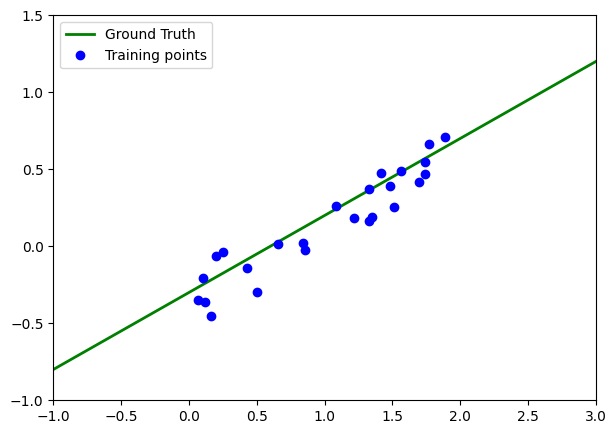

In [5]:
# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmax = 3, xmin =-1)
plt.ylim(ymax = 1.5, ymin = -1)
plt.plot(dataset_linear['X_test'], dataset_linear['y_test'], color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_linear['X_train'], dataset_linear['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

In [6]:
# Hyperparameters
dataset_linear['ALPHA'] = 2.0
dataset_linear['BETA'] = 1/(2.0*sigma**2)

We will use the linear basis function:
    $\phi:x \rightarrow (1,x)$

Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    1 & x_1 \\
    ... & ...\\
    1 & x_n
  \end{bmatrix}
$$

**Question 1.1: Code linear basis function**

In [7]:
#TO DO: Define basis function

def phi_linear(x):
    """ Linear Basis Functions

    Args:
      x: (float or array-like) 1D input

    Returns:
      (array) linear features of x
    """
    x = np.asarray(x)
    # if x.ndim == 1 :
    #     return np.column_stack((np.ones(x.shape[0]), x))
    # else :
    #     return np.array([1, x])
    return np.stack((np.ones(x.shape[0]), x),axis=1)

# Test
test_cases = [
    (np.array([1, 2, 3]), np.array([[1, 1], [1, 2], [1, 3]])),
    (np.array([0]), np.array([[1, 0]]))
    #(np.array([-1, 0, 1]), np.array([[1, -1], [1, 0], [1, 1]]))
]

for input_x, expected_output in test_cases:
    actual_output = phi_linear(input_x)
    print(f"Input: {input_x}, \n Expected: {expected_output}, \nActual:{actual_output}")
    np.testing.assert_array_equal(actual_output, expected_output)

print("All test cases passed!")

Input: [1 2 3], 
 Expected: [[1 1]
 [1 2]
 [1 3]], 
Actual:[[1. 1.]
 [1. 2.]
 [1. 3.]]
Input: [0], 
 Expected: [[1 0]], 
Actual:[[1. 0.]]
All test cases passed!


**Question 1.2: Recall closed form of the posterior distribution in linear case. Then, code and visualize posterior sampling. What can you observe?**  
  
**问题1.2：回忆线性情况下后验分布的闭合形式。然后，编码并可视化后验采样。你能观察到什么？**

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10180\2298191272.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  posterior[i,j] = np.exp(-0.5* np.dot(np.dot((w-mu_N.reshape(2,1)).T, np.linalg.inv(sigma_N)) , (w-mu_N.reshape(2,1)) ) )


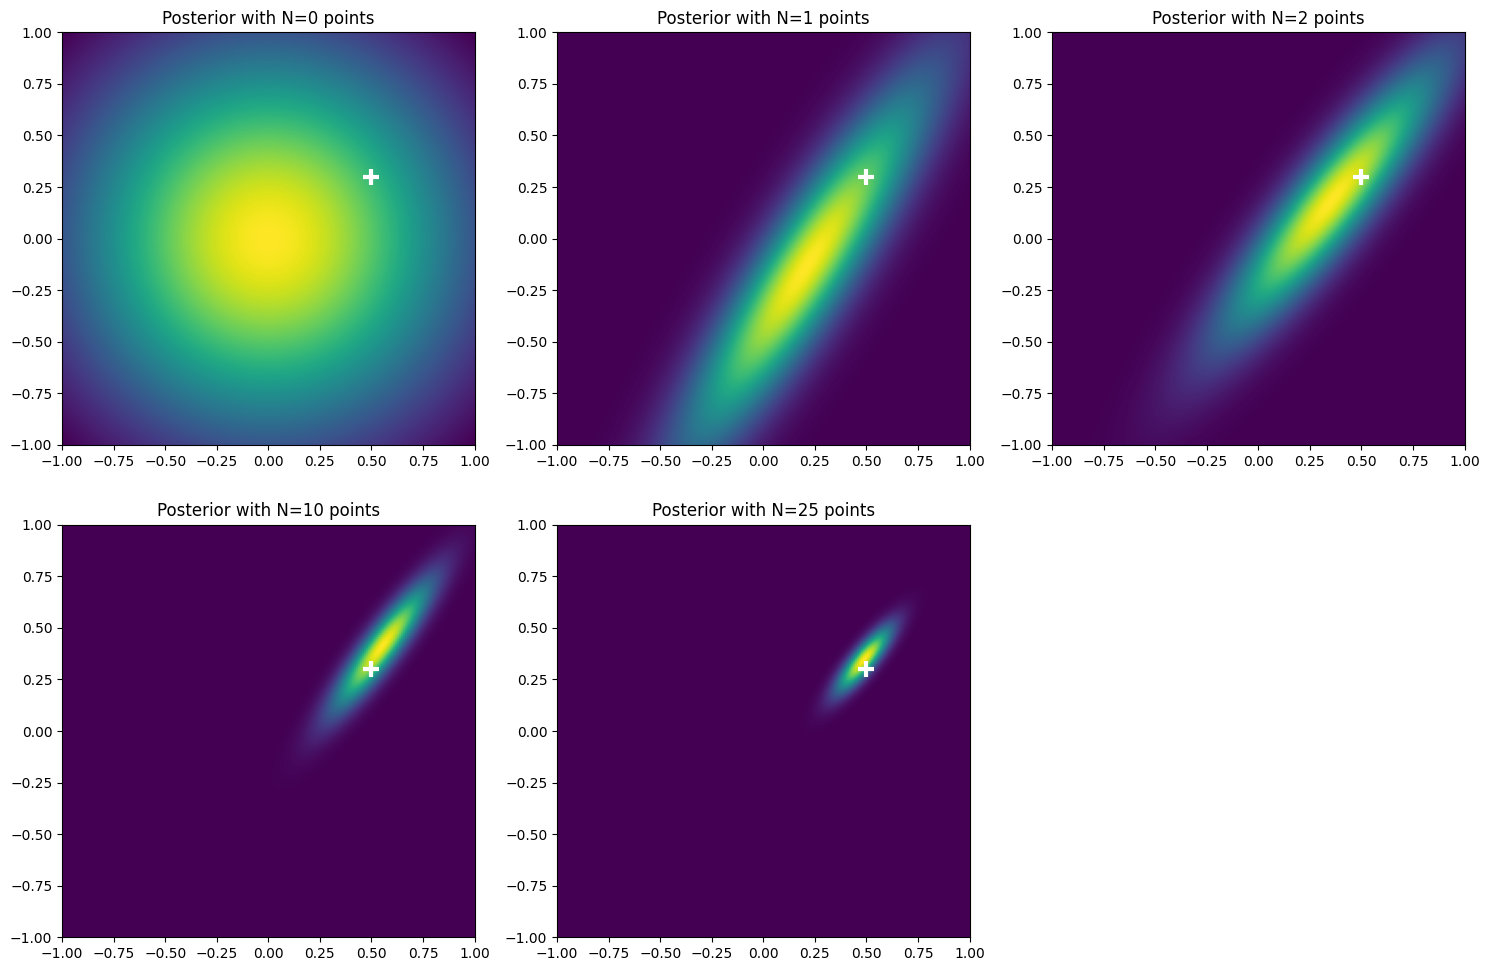

In [8]:
#TO DO: Code and visualize posterior sampling by completing code below

plt.figure(figsize=(15,10))
for count,n in enumerate([0,1,2,10,len(dataset_linear['X_train'])]):
    cur_data = dataset_linear['X_train'][:n] # 0,1,2,10,all samples
    cur_lbl = dataset_linear['y_train'][:n]
    meshgrid = np.arange(-1, 1.01, 0.01) #for w0,w1
    w = np.zeros((2,1))
    posterior = np.zeros((meshgrid.shape[0],meshgrid.shape[0]))

    # TO DO: code mu_n and sigma_N
    alpha = dataset_linear['ALPHA']
    beta = dataset_linear['BETA']
    Phi = phi_linear(cur_data)

    sigma_inv = alpha * np.eye(2) + beta * Phi.T @ Phi
    sigma_N = np.linalg.inv(sigma_inv)
    mu_N = beta * sigma_N @ ( Phi.T @ cur_lbl)
    #print(mu_N.shape)
    # Compute values on meshgrid
    for i in range(meshgrid.shape[0]):
        for j in range(meshgrid.shape[0]):
            w[0,0] = meshgrid[i]
            w[1,0] = meshgrid[j]
            posterior[i,j] = np.exp(-0.5* np.dot(np.dot((w-mu_N.reshape(2,1)).T, np.linalg.inv(sigma_N)) , (w-mu_N.reshape(2,1)) ) )
    Z = 1.0 / ( np.sqrt(2*np.pi* np.linalg.det(sigma_N) ) )
    posterior[:,:] /= Z

    # Plot posterior with n points
    plt.subplot(231+count)
    plt.imshow(posterior, extent=[-1,1,-1,1])
    plt.plot(0.5,0.3, '+', markeredgecolor='white', markeredgewidth=3, markersize=12)
    plt.title('Posterior with N={} points'.format(n))
plt.tight_layout()
plt.show()

**Question 1.3: Recall and code closed form of the predictive distribution in linear case.**    
需要实现一个贝叶斯线性回归的闭合解（Closed-Form Solution），返回一个预测函数，用于在给定新输入𝑥时，计算预测分布的均值和标准差。

In [28]:
#TO DO: Code closed form solution according to the following requirements defined below

def closed_form(func, X_train, y_train, alpha, beta):
    """Define analytical solution to Bayesian Linear Regression, with respect to the basis function chosen, the
    training set (X_train, y_train) and the noise precision parameter beta and prior precision parameter alpha chosen.
    It should return a function outputing both mean and std of the predictive distribution at a point x*.

    Args:
      func: (function) the basis function used
      X_train: (array) train inputs, sized [N,]
      y_train: (array) train labels, sized [N, ]
      alpha: (float) prior precision parameter
      beta: (float) noise precision parameter

    Returns:
      (function) prediction function, returning itself both mean and std
    """

    #TO DO 需要算出pred的均值与方差 #按照老师的操作，最终的pre出来应该是（n，）的形状，矩阵计算后直接返回
    def f_model(x) :
      Phi = func(X_train)
      sigma_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T @ Phi
      sigma_N = np.linalg.inv(sigma_inv)
      # print(sigma_N.shape)
      mu_N = beta * sigma_N @ ( Phi.T @ y_train)  #这里cur是什么莫名其妙
      # print(mu_N.shape)
      
      Phi_new = func(x) #250,2
      # print(mu_N.shape,Phi_new.shape)
      u_pred = Phi_new @ mu_N
      # using einsum to simplify the code
      sigma_2_pred = 1/beta + np.einsum('ij,jk,ik->i', Phi_new, sigma_N, Phi_new)
      std_pred = np.sqrt(sigma_2_pred)
      return u_pred.reshape(-1,),std_pred#sigma_2_pred
    return f_model
f_pred = closed_form(phi_linear, dataset_linear['X_train'], dataset_linear['y_train'],
                     dataset_linear['ALPHA'], dataset_linear['BETA'])

**Question 1.4: Based on previously defined ``f_pred()``, predict on the test dataset. Then visualize results using ``plot_results()`` defined at the beginning of the notebook.**  
用f_pred 在测试集上使用（会超出原有的界限）在用plot画出来

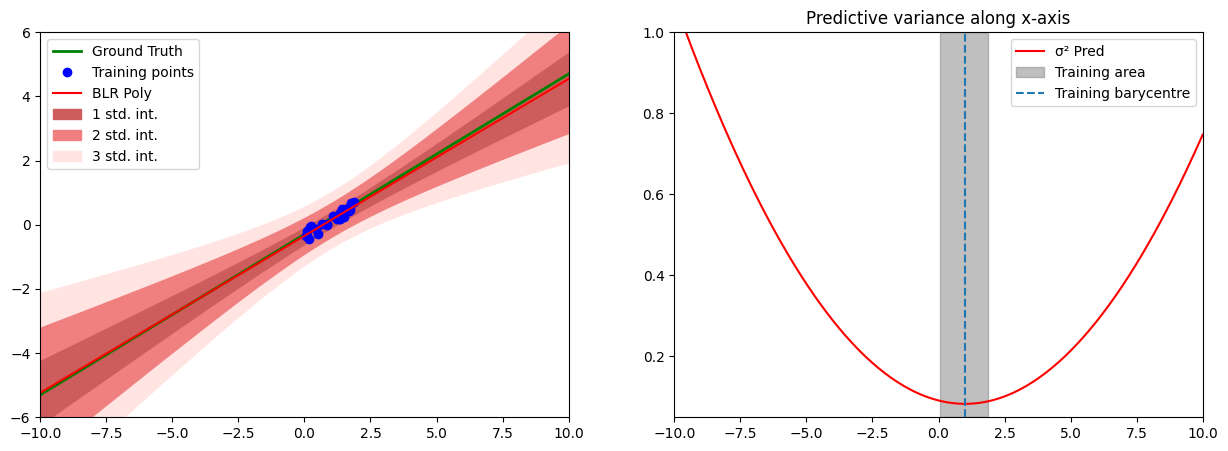

In [ ]:
# TO DO : predict on test dataset and visualize results
u_pred, std_pred = f_pred(dataset_linear['X_test'])
plot_results(dataset_linear['X_train'], dataset_linear['y_train'],
             dataset_linear['X_test'], dataset_linear['y_test'], u_pred, std_pred,
             xmin=-10, xmax=10, ymin=-6, ymax=6, stdmin=0.05, stdmax=1)
# xmin=-10, xmax=10, ymin=-6, ymax=6, stdmin=0.05, stdmax=1


**Question 1.5: Analyse these results. Why predictive variance increases far from training distribution? Prove it analytically in the case where $\alpha=0$ and $\beta=1$.**

**Bonus Question: What happens when applying Bayesian Linear Regression on the following dataset?**

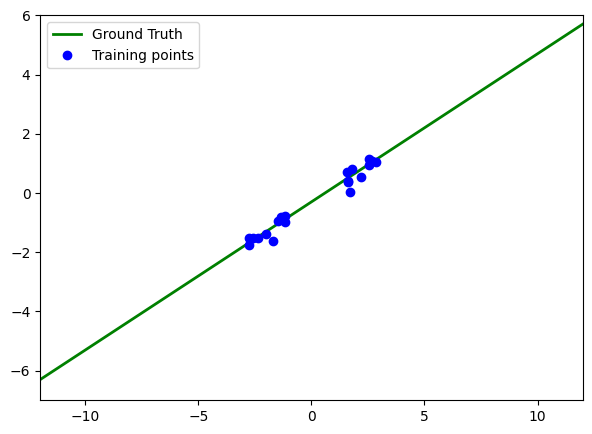

In [12]:
# Create training and test points
sigma = 0.2
dataset_hole = {}
dataset_hole['X_train'] = np.concatenate(([np.random.uniform(-3, -1, 10), np.random.uniform(1, 3, 10)]), axis=0)
dataset_hole['y_train'] = f_linear(dataset_hole['X_train'], noise_amount=1,sigma=sigma)
dataset_hole['X_test'] = np.linspace(-12,12, 100)
dataset_hole['y_test'] = f_linear(dataset_hole['X_test'], noise_amount=0,sigma=sigma)
dataset_hole['ALPHA'] = 2.0
dataset_hole['BETA'] = 1/(2.0*sigma**2)

# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-12, xmax = 12)
plt.ylim(ymin = -7, ymax = 6)
plt.plot(dataset_hole['X_test'], dataset_hole['y_test'], color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_hole['X_train'], dataset_hole['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

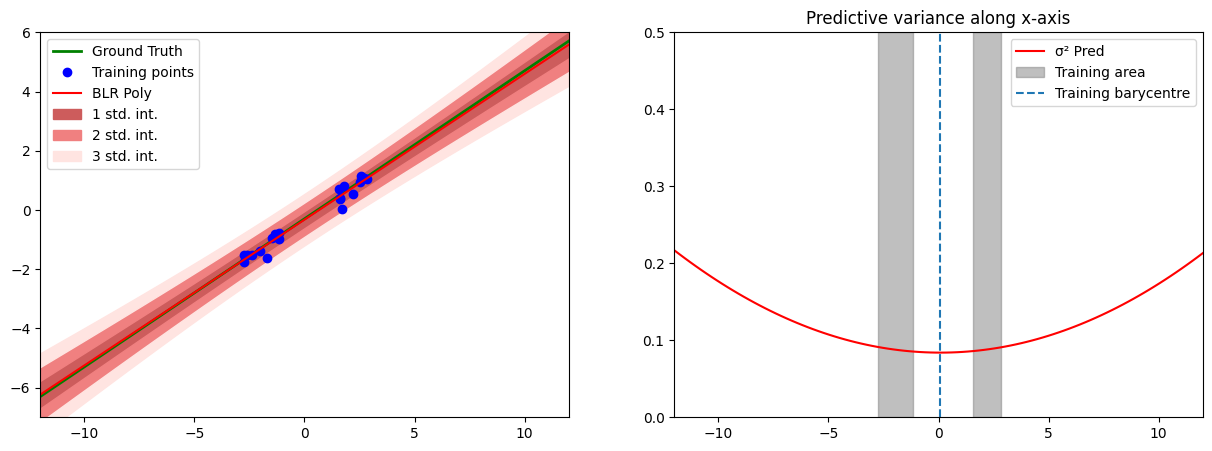

In [18]:
# TO DO: Define f_pred, predict on test points and plot results
f_pred = closed_form(phi_linear, dataset_hole['X_train'], dataset_hole['y_train'],
                     dataset_hole['ALPHA'], dataset_hole['BETA'])
u_pred, std_pred = f_pred(dataset_hole['X_test'])
plot_results(dataset_hole['X_train'], dataset_hole['y_train'], dataset_hole['X_test'], dataset_hole['y_test'],
             u_pred, std_pred,
             xmin=-12, xmax=12, ymin=-7, ymax=6, stdmin=0.0, stdmax=0.5)
# You should use the following parameters for plot_results
# xmin=-12, xmax=12, ymin=-7, ymax=6, stdmin=0.0, stdmax=0.5

## Part II: Non Linear models

We now introduce a more complex toy dataset, which is an increasing sinusoidal curve. The goal of this part is to get insight on the importance of the chosen basis function on the predictive variance behavior.   
引入一条递增的正弦曲线。这一部分的目标是了解所选择的基函数对预测方差行为的重要性。

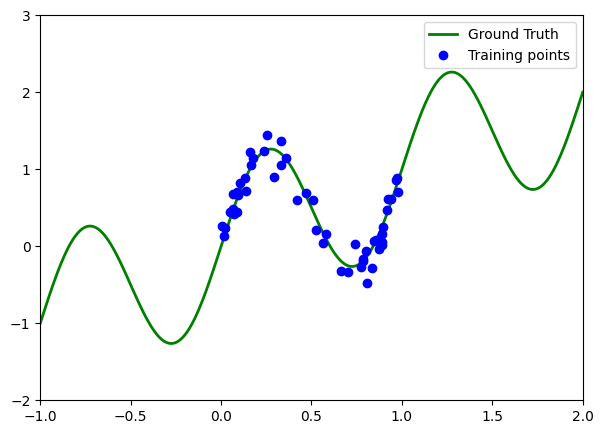

In [19]:
# Generate sinusoidal toy dataset
# y = sin(2*pi*x) + x + noise
def f_sinus(x, noise_amount,sigma=0.2):
    y = np.sin(2*np.pi*x) + x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount * noise 

# Create training and test points
sigma=0.2
nbpts=50
dataset_sinus = {} 
#between 0,1
dataset_sinus['X_train'] = np.random.uniform(0, 1, nbpts)
dataset_sinus['y_train'] = f_sinus(dataset_sinus['X_train'], noise_amount=1,sigma=sigma)
dataset_sinus['X_test'] = np.linspace(-1,2, 10*nbpts)
dataset_sinus['y_test'] = f_sinus(dataset_sinus['X_test'], noise_amount=0,sigma=sigma)

dataset_sinus['ALPHA'] = 0.05
dataset_sinus['BETA'] = 1/(2.0*sigma**2)


# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-1, xmax = 2)
plt.ylim(ymin = -2, ymax = 3)
plt.plot(dataset_sinus['X_test'], dataset_sinus['y_test'], color='green', linewidth=2,
         label="Ground Truth")
plt.plot(dataset_sinus['X_train'], dataset_sinus['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

### II.1 Polynomial basis functions

We will first use polynomial basis functions:
$$\phi:x \rightarrow (\phi_0,\phi_1,...,\phi_{D-1})$$
where $\phi_j = x^j$ for $j \geq 0$ and $D \geq 0$


Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    1 & x_1 & x_1^2 &... &x_1^{D-1} \\
    ... & ... & ... & ...\\
    1 & x_n & x_n^2 &... &x_n^{D-1}
  \end{bmatrix}
$$

**Question 2.1: Code polynomial basis function**

In [29]:
# Define basis function
def phi_polynomial(x):
    """ Polynomial Basis Functions

    Args:
      x: (float) 1D input

    Returns:
      (array) polynomial features of x
    """
    x = np.asarray(x)
    D = 10
    return np.vander(x, N=D, increasing=True)
print(phi_polynomial([1,2]))

[[  1   1   1   1   1   1   1   1   1   1]
 [  1   2   4   8  16  32  64 128 256 512]]


**Question 2.2 : Code and visualize results on sinusoidal dataset using polynomial basis functions. What can you say about the predictive variance?**  

使用多项式基函数在正弦数据集上编写代码并可视化结果。关于预测方差你能说些什么呢

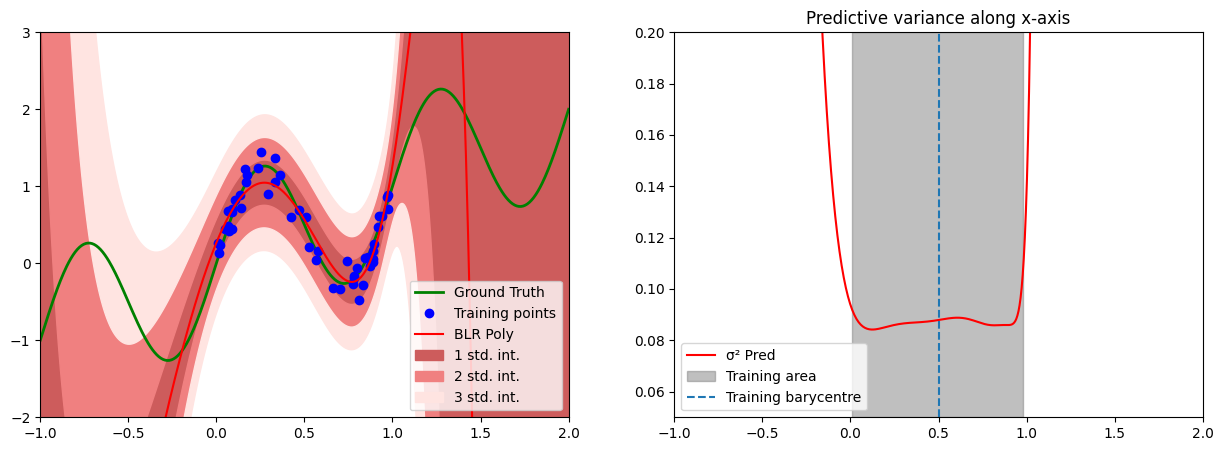

In [30]:
# TO DO: Define f_pred, predict on test points and plot results
f_pred_poly = closed_form(phi_polynomial, dataset_sinus['X_train'], dataset_sinus['y_train'],
                     dataset_sinus['ALPHA'], dataset_sinus['BETA'])

u_pred_poly, std_pred_poly = f_pred_poly(dataset_sinus['X_test'])
plot_results(dataset_sinus['X_train'], dataset_sinus['y_train'], dataset_sinus['X_test'], dataset_sinus['y_test'],
             u_pred_poly, std_pred_poly,
             xmin=-1, xmax=2, ymin=-2, ymax=3, stdmin=0.05, stdmax=0.2)
# You should use the following parameters for plot_results
# xmin=-1, xmax=2, ymin=-3, ymax=5, stdmin=0, stdmax=10

### II.2 Gaussian basis functions

Now, let's consider gaussian basis functions:
$$\phi:x \rightarrow (\phi_0,\phi_1,...,\phi_M)$$
where $\phi_j = \exp \Big ( -\frac{(x-\mu_j)^2}{2s^2} \Big )$ for $j \geq 0$


Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    \phi_0(x_1) & \phi_1(x_1) &... &\phi_M(x_1) \\
    ... & ... & ... & ...\\
    \phi_0(x_n) & \phi_1(x_n) &... &\phi_M(x_n)
  \end{bmatrix}
$$

**Question 2.3: Code gaussian basis function**

In [42]:
#TO DO: Define Gaussian basis function
MU_MIN = 0
MU_MAX = 1
M = 9

def phi_gaussian(x) :
    """ Gaussian Basis Functions

    Args:
      x: (float) 1D input

    Returns:
      (array) gaussian features of x
    """
    x = np.asarray(x) #shape (N, )
    s = (MU_MAX-MU_MIN)/M     
    centers = np.linspace(MU_MIN, MU_MAX, M) # shape (M, )
    #cant directly (N,)-M(M, ) so we expand x to (N, 1)
    x = np.expand_dims(x, axis=-1)  # shape (N, 1)
    #(N,1)-(M,)
    return np.exp(-(x - centers) ** 2 / (2 * s * s))
phi_gaussian([0.5,0.6])


array([[4.00652974e-05, 3.36168649e-03, 7.95595087e-02, 5.31095991e-01,
        1.00000000e+00, 5.31095991e-01, 7.95595087e-02, 3.36168649e-03,
        4.00652974e-05],
       [4.65571572e-07, 1.07522277e-04, 7.00416715e-03, 1.28694680e-01,
        6.66976811e-01, 9.75005175e-01, 4.02021383e-01, 4.67560088e-02,
        1.53381068e-03]])

In [41]:
# x = np.array([1, 2])
# print(x.shape)
# y = np.expand_dims(x, axis=(0, 1))
# print(y.shape)
# y = np.expand_dims(x, axis=(2,0))
# print(y.shape)



**Question 2.4 : Code and visualize results on sinusoidal dataset using Gaussian basis functions. What can you say this time about the predictive variance?**

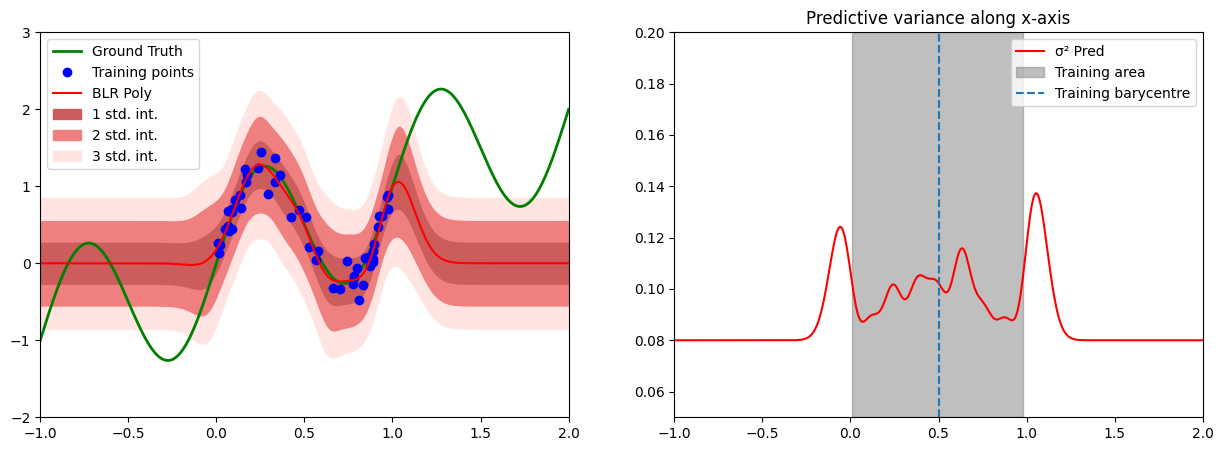

In [43]:
# TO DO: Define f_pred, predict on test points and plot results
f_pred_gaussian = closed_form(phi_gaussian, dataset_sinus['X_train'], dataset_sinus['y_train'],
                              dataset_sinus['ALPHA'], dataset_sinus['BETA'])

u_pred_gaussian, std_pred_gaussian = f_pred_gaussian(dataset_sinus['X_test'])
plot_results(dataset_sinus['X_train'], dataset_sinus['y_train'], dataset_sinus['X_test'], dataset_sinus['y_test'],
             u_pred_gaussian, std_pred_gaussian,
             xmin=-1, xmax=2, ymin=-2, ymax=3, stdmin=0.05, stdmax=0.2)

# You should use the following parameters for plot_results
# xmin=-1, xmax=2, ymin=-2, ymax=3, stdmin=0.05, stdmax=0.2

**Question 2.5: Explain why in regions far from training distribution, the predictive variance converges to this value when using localized basis functions such as Gaussians.**

Answer:
1. **Stable Variance**
- Variance formula:  
$$
\sigma^2(x^*) = \frac{1}{\beta} + \phi(x^*)^\top \Sigma_N \phi(x^*)
$$

2. **Mean Deviation**
- **Gaussian Basis Locality**: Basis functions vanish (\(\phi(x^*) \approx 0\)) far from training data.
- **Posterior Weight**: Predictions revert to the prior distribution.
- **Model Limitation**: Lacks constraints on function trends in data-sparse areas.

 3. **Why Variance Doesn't Increase?**
- Variance mainly reflects noise (\(\frac{1}{\beta}\)) and stable posterior covariance contributions, regardless of mean accuracy.

 4. **Improvements**
- **Increase Training Range**: Add data in sparse regions.
- **Adjust Basis Parameters**: Reduce kernel width or increase kernel count.
- **Use Global Basis**: Use polynomial or sinusoidal basis for global trends.
- **Regularization**: Increase prior precision (\(\alpha\)) to reduce deviation.

